<a href="https://colab.research.google.com/github/MihailMV/Fruits-and-vegetables/blob/master/NN_fruits_and_vegetables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
import zipfile
import shutil
import numpy as np
from tqdm import tqdm

In [0]:
DIR = 'fruits_vegetables'
DIR_TRAIN = 'TRAIN'
DIR_VAL = 'VAL'
DIR_TEST = 'TEST'
IMG_SIZE = (224, 224)
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])
BATCH_SIZE = 100

os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/kaggle/" 

In [4]:
!kaggle datasets download -d balalexv/fruits-vegetables-photos
with zipfile.ZipFile('/content/fruits-vegetables-photos.zip', 'r') as zip_obj:
   zip_obj.extractall('/content/')
!rm '/content/fruits-vegetables-photos.zip'

100% 1.80G/1.80G [00:35<00:00, 33.6MB/s]
100% 1.80G/1.80G [00:36<00:00, 53.6MB/s]


In [0]:
os.makedirs(os.path.join(DIR, DIR_VAL), exist_ok=True)
for class_name in os.listdir(os.path.join(DIR,DIR_TRAIN)):
  os.makedirs(os.path.join(DIR, DIR_VAL, class_name), exist_ok=True)
  for i, f in enumerate(os.listdir(os.path.join(DIR,DIR_TRAIN, class_name))):
    if (i % 5 == 0):
      shutil.move(os.path.join(DIR,DIR_TRAIN, class_name,f), os.path.join(DIR,DIR_VAL,class_name,f))

In [0]:
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torchvision
import torch
import matplotlib.pyplot as plt

In [0]:
train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    #transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TRAIN), train_transforms)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_VAL), val_transforms)


In [0]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


In [0]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = STD * image + MEAN
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)


In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
  hist_loss_train = []
  hist_acc_train = []
  hist_loss_val = []
  hist_acc_val = []
  for epoch in range(num_epochs):
    # Train
    running_loss = 0.
    running_acc = 0.
    scheduler.step()
    model.train()
    for inputs, labels in tqdm(train_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      with torch.set_grad_enabled(True):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        loss_value.backward()
        optimizer.step()
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()
        loss_train = running_loss / len(train_dataloader)
        acc_train = running_acc / len(train_dataloader)
        
    # Val
    running_loss = 0.
    running_acc = 0.
    model.eval()
    for inputs, labels in val_dataloader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      with torch.set_grad_enabled(False):
        preds = model(inputs)
        loss_value = loss(preds, labels)
        preds_class = preds.argmax(dim=1)
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()
        loss_val = running_loss / len(val_dataloader)
        acc_val = running_acc / len(val_dataloader)
    
    print(f'Epoch {epoch}/{num_epochs - 1}: Train: Loss: {loss_train:.4f}, Acc: {acc_train:.4f}   Val: Loss: {loss_val:.4f}, Acc: {acc_val:.4f}', flush=True)
    hist_loss_train.append(loss_train)
    hist_acc_train.append(acc_train.item())
    hist_loss_val.append(loss_val)
    hist_acc_val.append(acc_val.item())

  return model, [hist_loss_train,hist_acc_train,hist_loss_val,hist_acc_val]

In [51]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(train_dataset.classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-2)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s] 


In [52]:
model, hist = train_model(model, loss, optimizer, scheduler, num_epochs=10);

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 39/39 [00:39<00:00,  1.53it/s]


Epoch 0/9: Train: Loss: 1.2317, Acc: 0.6639   Val: Loss: 0.3014, Acc: 0.9035


100%|██████████| 39/39 [00:39<00:00,  1.54it/s]


Epoch 1/9: Train: Loss: 0.2340, Acc: 0.9290   Val: Loss: 0.1640, Acc: 0.9434


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Epoch 2/9: Train: Loss: 0.1694, Acc: 0.9478   Val: Loss: 0.1321, Acc: 0.9574


100%|██████████| 39/39 [00:39<00:00,  1.57it/s]


Epoch 3/9: Train: Loss: 0.1242, Acc: 0.9646   Val: Loss: 0.1308, Acc: 0.9574


100%|██████████| 39/39 [00:39<00:00,  1.54it/s]


Epoch 4/9: Train: Loss: 0.1048, Acc: 0.9680   Val: Loss: 0.1213, Acc: 0.9542


100%|██████████| 39/39 [00:39<00:00,  1.55it/s]


Epoch 5/9: Train: Loss: 0.1028, Acc: 0.9697   Val: Loss: 0.1047, Acc: 0.9684


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Epoch 6/9: Train: Loss: 0.0769, Acc: 0.9770   Val: Loss: 0.0831, Acc: 0.9764


100%|██████████| 39/39 [00:39<00:00,  1.02s/it]


Epoch 7/9: Train: Loss: 0.0696, Acc: 0.9834   Val: Loss: 0.0809, Acc: 0.9754


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Epoch 8/9: Train: Loss: 0.0681, Acc: 0.9846   Val: Loss: 0.0797, Acc: 0.9744


100%|██████████| 39/39 [00:40<00:00,  1.03s/it]


Epoch 9/9: Train: Loss: 0.0648, Acc: 0.9862   Val: Loss: 0.0793, Acc: 0.9754


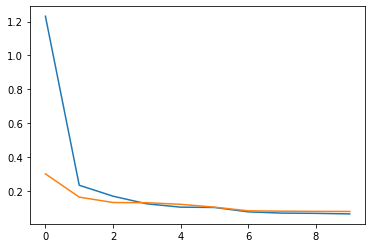

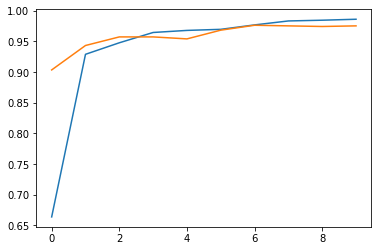

In [53]:
plt.plot(hist[0])
plt.plot(hist[2])
plt.show()

plt.plot(hist[1])
plt.plot(hist[3])
plt.show()


In [0]:
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DIR,DIR_TEST), val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [55]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 117
    Root location: fruits_vegetables/TEST
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

In [56]:
model.eval()

test_predictions = []
test_img_paths = []

running_loss = 0.
running_acc = 0.

for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        preds_class = preds.argmax(dim=1)
        running_acc += (preds_class == labels.data).float().sum().cpu()


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


In [50]:
running_acc / 117, 117 - running_acc

(tensor(0.8205), tensor(21.))

In [57]:
running_acc / 117, 117 - running_acc

(tensor(0.8205), tensor(21.))